In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!nvidia-smi

Tue Nov 22 07:54:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 12.6 MB/s 
     |████████████████████████████████| 182 kB 68.1 MB/s 
     |████████████████████████████████| 168 kB 69.3 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
     |████████████████████████████████| 166 kB 76.0 MB/s 
     |████████████████████████████████| 166 kB 78.7 MB/s 
     |████████████████████████████████| 162 kB 73.1 MB/s 
     |████████████████████████████████| 162 kB 71.7 MB/s 
     |████████████████████████████████| 158 kB 78.0 MB/s 
     |████████████████████████████████| 157 kB 75.7 MB/s 
     |████████████████████████████████| 157 kB 76.7 MB/s 
     |████████████████████████████████| 157 kB 80.2 MB/s 
     |████████████████████████████████| 157 kB 79.3 MB/s 
     |████████████████████████████████| 157 kB 80.3 MB/s 
     |████████████████████████████████| 157 kB 75.6 MB/s 
     |███████████████████████████

In [ ]:
!pip install opensmile

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.5 MB 14.3 MB/s 
     |████████████████████████████████| 635 kB 61.8 MB/s 
     |████████████████████████████████| 48 kB 6.0 MB/s 
     |████████████████████████████████| 167 kB 63.7 MB/s 
  Created wheel for iso-639: filename=iso_639-0.4.5-py3-none-any.whl size=169062 sha256=7e954be942f98a520fbf2e38b297e234d5ac227d9551956d188d55d35b288a82
  Stored in directory: /root/.cache/pip/wheels/47/60/19/6d020fc92138ed1b113a18271e83ea4b5525fe770cb45b9a2e
Successfully built iso-639


In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torchsummary import summary
import torchaudio.transforms as T
import torchaudio
import pickle
import matplotlib.pyplot as plt
import librosa

from tqdm import tqdm, trange
import os
import sys
from pathlib import Path
from datetime import datetime
import random
from random import randint

import gc
import wandb
import opensmile

import time

# Data gaining

In [ ]:
!unzip -q /content/gdrive/MyDrive/data_2.zip

In [ ]:
ROOT = "data_2/"
ALL_SOUNDS = list(Path(ROOT).glob("**/*.wav"))
ALL_SOUNDS = list(filter(lambda x: not x.name.startswith("."), ALL_SOUNDS))
print("Number of sounds:", len(ALL_SOUNDS))

Number of sounds: 97377


In [ ]:
data_list = []
with open('/content/gdrive/MyDrive/data_base_2.pickle', 'rb') as fh:
  data_list = pickle.load(fh)

In [ ]:
len(data_list)

97377

In [ ]:
random.seed(123456)
np.random.seed(123456)
torch.manual_seed(123456)

# Data preporation

**Baseline**

In [ ]:
class SoundDataset_baseline(torch.utils.data.Dataset):
    def __init__(self, rootdir, subset, transform=None):
        self.transform = transform
        self.rootdir = rootdir
        self.subset = subset

    def __getitem__(self, index):
        xname, y = self.subset[index].values()
        X, _ = librosa.load(f"{self.rootdir}/{xname}.wav", sr=8000)
        if self.transform:
            X = torch.unsqueeze(self.transform(X.astype('float32')), 0)
            y = torch.unsqueeze(self.transform(y.astype('float32')), 0)
        return xname, X, y, -1

    def __len__(self):
        return len(self.subset)

class ToTensor(object):
    def __call__(self, sample):
        return torch.from_numpy(sample)

**MFCC**

In [ ]:
class SoundDataset_feature_map(torch.utils.data.Dataset):
    def __init__(self, rootdir, subset, transform=None):
        self.transform = transform
        self.rootdir = rootdir
        self.subset = subset
        self.mfcc_transform = T.MFCC(
            sample_rate=8000,
            n_mfcc=256,
            melkwargs={
                "n_fft": 2048,
                "n_mels": 256,
                "hop_length": 512,
                "mel_scale": "htk",
            },
        )

    def __getitem__(self, index):
        xname, y = self.subset[index].values()
        signal, sr = librosa.load(f"{self.rootdir}/{xname}.wav", sr=8000)
        if self.transform:
            X = torch.unsqueeze(self.mfcc_transform(self.transform(signal)), 0)
            y = torch.unsqueeze(self.transform(y.astype('float32')), 0)
            signal = torch.unsqueeze(self.transform(signal.astype('float32')), 0)

        return xname, X, y, signal

    def __len__(self):
        return len(self.subset)

**eGMAPSv02**

In [ ]:
class SoundDataset_eGMAPSv02(torch.utils.data.Dataset):
    def __init__(self, rootdir, subset, transform=None):
        self.transform = transform
        self.rootdir = rootdir
        self.subset = subset
        self.n_subset = len(self.subset)
        self.smile = opensmile.Smile(
                        feature_set=opensmile.FeatureSet.eGeMAPSv02,
                        feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
                        )
        # self.data = []
        # self.preprocessing()

    def __getitem__(self, index):
        xname, y = self.subset[index].values()
        if self.transform:
            X = torch.unsqueeze(torch.transpose(self.transform(self.smile.process_file(f"{self.rootdir}/{xname}.wav").to_numpy().astype('float32')).cuda(), 0, 1), 0)
            y = torch.unsqueeze(self.transform(y.astype('float32')).cuda(), 0)
            # signal = torch.unsqueeze(signal, 0)

        return xname, X, y, -1

    def __len__(self):
        return len(self.subset)

    # def preprocessing(self):
    #     for i in tqdm(np.arange(self.n_subset)):
 
    #         # signal, sr = librosa.load(f"{self.rootdir}/{xname}.wav", sr=8000)
    #         data_features = 
    #         self.data.append(data_features)

**For graphs**

In [ ]:
def find_words_edges(marks):
    lst = np.array([[0, 0]])
    flag = False
    temp = []
    for i in np.arange(len(marks)):
        if marks[i] == 1 and flag == False:
            temp.append(i / 10000)
            flag = True
        if marks[i] == 0 and flag == True:
            temp.append(i / 10000)
            flag = False
            lst = np.append(lst, [temp], axis=0)
            temp = []
    return lst[1:]

In [ ]:
def plot_signal_spectrogram(signal, specgram, title=None, ylabel="freq_bin"):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))
    inp = torch.squeeze(signal).cpu().numpy()
    time = np.linspace(0., inp.size/8000, inp.size)
    ax1.set_title(title)
    ax1.plot(time, inp)
    ax2.set_title("Spectrogram (db)")
    ax2.set_ylabel(ylabel)
    ax2.set_xlabel("frame")
    im = ax2.imshow(librosa.power_to_db(specgram.cpu()), origin="lower", aspect="auto")

    fig.colorbar(im, ax=ax2)

    plt.show()

In [ ]:
def sound_show(inp, title=None, marks_true=None, marks_pred=None):
    inp = torch.squeeze(inp).cpu().numpy()
    time = np.linspace(0., inp.size/8000, inp.size)
    height = 1.5*np.max(inp)
    plt.figure(figsize=(16, 8))
    signal = plt.plot(time, inp)
    plt.title(title)
    try:
        if marks_pred is not None or marks_true is not None:
            marks_true = torch.squeeze(marks_true).cpu().numpy()
            marks_pred = torch.squeeze(marks_pred.detach()).cpu().numpy()
            words_grid_true = find_words_edges(marks_true)
            words_grid_pred = find_words_edges(marks_pred)

            for edges in words_grid_pred:
                edges_pred_0 = plt.vlines(edges[0], -height, height, colors='green', linewidth=2)
                edges_pred_1 = plt.vlines(edges[1], -height, height, colors='green', linewidth=2)

            for edges in words_grid_true:
                edges_true = []
                edges_true_0 = plt.vlines(edges[0], -height, height, colors='red', linewidth=2, linestyles='dashed')
                edges_true_1 = plt.vlines(edges[1], -height, height, colors='red', linewidth=2, linestyles='dashed')
            plt.legend([signal, edges_true_0, edges_pred_0], ['Signal', 'True edges', 'Predicted edges'])
    except UnboundLocalError:
        pass
    plt.show()

**Splitting subset**

In [ ]:
path_data = '/content/data_2'

end_idx_tv = 87000
train_valid_subset = data_list[:end_idx_tv]
test_subset = data_list[end_idx_tv:]

lengths = [int(len(train_valid_subset) * 0.9), int(len(train_valid_subset) * 0.1)]
train_subset, valid_subset = torch.utils.data.random_split(train_valid_subset, lengths)
print(train_subset[0])

{'name': '7a263d8418b34994ad76a38298347100_SNR_3', 'marks': array([0, 0, 0, ..., 0, 0, 0], dtype=int8)}


In [ ]:
del data_list

In [ ]:
gc.collect()

88

In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=1192d91d1be0e44af8bd3f8eede7b5bb47ed8cafd0bb1f9ce4deb66e673eff11
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Gen RAM Free: 6.7 GB  | Proc size: 5.4 GB
GPU RAM Free: 15109MB | Used: 0MB | Util   0% | Total 15109MB


**Baseline dataset**

{'train': 78300, 'valid': 8700, 'test': 10377}


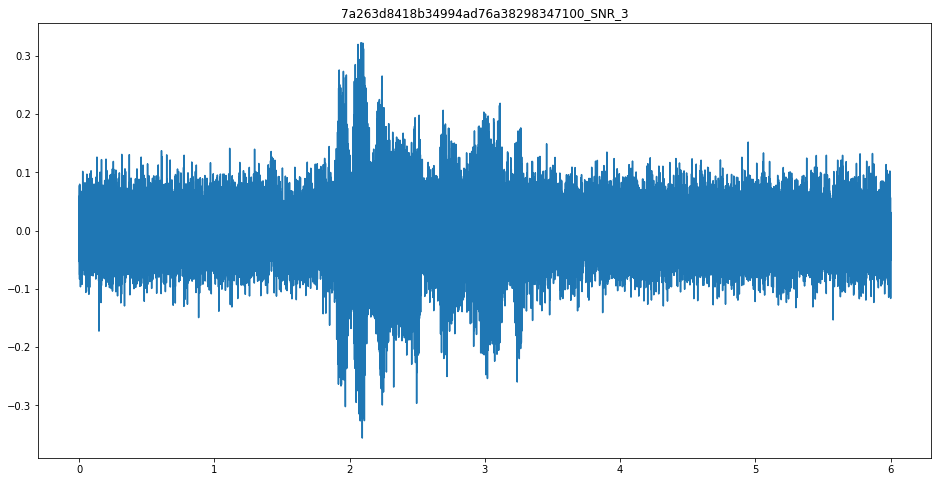

In [ ]:
transform_baseline = transforms.Compose([ToTensor()])
data_set_baseline = {
            'train': SoundDataset_baseline(rootdir=path_data, subset=train_subset, transform=transform_baseline),
            'valid': SoundDataset_baseline(rootdir=path_data, subset=valid_subset, transform=transform_baseline),
            'test': SoundDataset_baseline(rootdir=path_data, subset=test_subset, transform=transform_baseline)
           }

batch_size = 512
loaders_baseline = {
            'train': torch.utils.data.DataLoader(data_set_baseline['train'], batch_size=batch_size, shuffle=True),
            'valid': torch.utils.data.DataLoader(data_set_baseline['valid'], batch_size=batch_size, shuffle=True),
            'test': torch.utils.data.DataLoader(data_set_baseline['test'], batch_size=1, shuffle=False)
          }

dataset_sizes = {x: len(data_set_baseline[x]) for x in ['train', 'valid', 'test']}
xname, X, y, _ = data_set_baseline['train'][0]
print(dataset_sizes)
sound_show(X, title=f'{xname}', marks_true=None, marks_pred=None)

**Feature map dataset**

tensor([[[ 6.2230e+01,  7.4918e+01,  7.7053e+01,  ...,  7.6772e+01,
           7.3867e+01,  7.3573e+01],
         [-4.5902e+01, -4.2576e+01, -4.5886e+01,  ..., -4.5031e+01,
          -4.1677e+01, -4.3152e+01],
         [-3.5554e+00,  6.2458e-01, -1.9358e+00,  ..., -4.3994e+00,
          -3.7113e-01, -3.0118e+00],
         ...,
         [ 2.9003e+00,  1.5111e+00,  6.2143e-01,  ..., -2.5847e+00,
          -1.4466e+00, -3.6700e-01],
         [-6.1708e-02, -4.7170e-02, -1.3880e+00,  ..., -1.4469e+00,
          -1.1833e+00,  7.4534e-02],
         [ 2.5186e+00,  1.9197e+00, -1.8651e-01,  ...,  9.4582e-01,
           2.5797e+00, -1.1986e+00]]]) tensor([[0., 0., 0.,  ..., 0., 0., 0.]]) tensor([[-0.0482,  0.0134, -0.0107,  ...,  0.0108, -0.1163, -0.0239]])
{'train': 78300, 'valid': 8700, 'test': 10377}


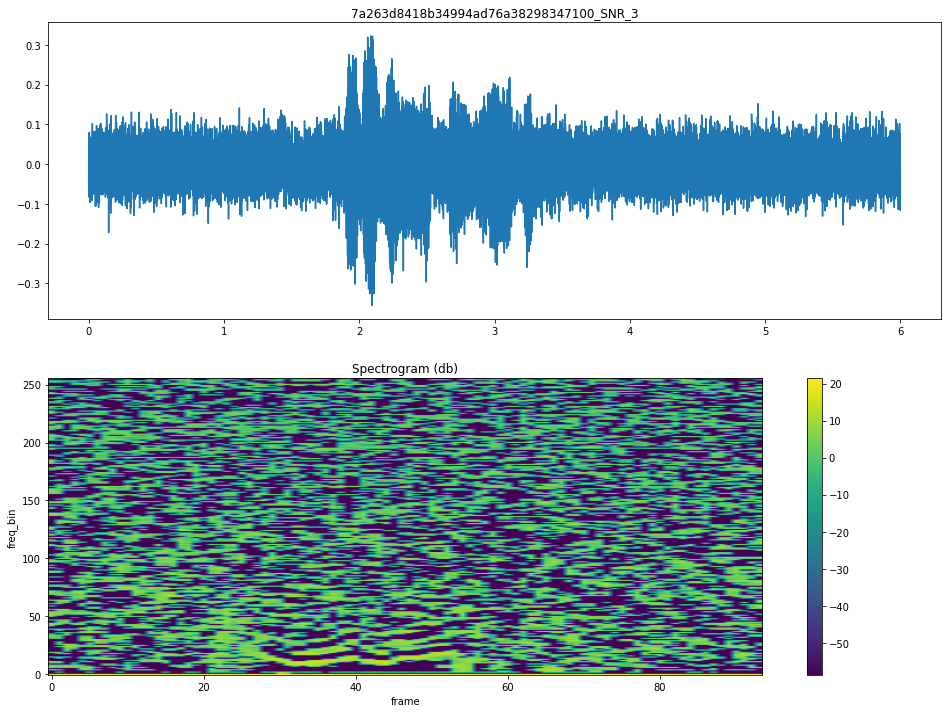

In [ ]:
transform_feature_map = transforms.Compose([ToTensor()])
data_set_feature_map = {
            'train': SoundDataset_feature_map(rootdir=path_data, subset=train_subset, transform=transform_feature_map),
            'valid': SoundDataset_feature_map(rootdir=path_data, subset=valid_subset, transform=transform_feature_map),
            'test': SoundDataset_feature_map(rootdir=path_data, subset=test_subset, transform=transform_feature_map)
           }

batch_size = 512
loaders_feature_map = {
            'train': torch.utils.data.DataLoader(data_set_feature_map['train'], batch_size=batch_size, shuffle=True),
            'valid': torch.utils.data.DataLoader(data_set_feature_map['valid'], batch_size=batch_size, shuffle=True),
            'test': torch.utils.data.DataLoader(data_set_feature_map['test'], batch_size=1, shuffle=False)
          }

dataset_sizes = {x: len(data_set_feature_map[x]) for x in ['train', 'valid', 'test']}
xname, X, y, signal = data_set_feature_map['train'][0]
print(X, y, signal)
print(dataset_sizes)
# sound_show(signal, title=f'SNR_{xname.split("_SNR_")[1]}', marks_true=None, marks_pred=None)
plot_signal_spectrogram(signal, X[0], title=xname)
print(X[0].size())

**eGMAPSv02 dataset**

In [ ]:
transform_eGMAPSv02 = transforms.Compose([ToTensor()])
data_set_eGMAPSv02 = {
            'train': SoundDataset_eGMAPSv02(rootdir=path_data, subset=train_subset, transform=transform_eGMAPSv02),
            'valid': SoundDataset_eGMAPSv02(rootdir=path_data, subset=valid_subset, transform=transform_eGMAPSv02),
            'test': SoundDataset_eGMAPSv02(rootdir=path_data, subset=test_subset, transform=transform_eGMAPSv02)
           }

batch_size = 512
loaders_eGMAPSv02 = {
            'train': torch.utils.data.DataLoader(data_set_eGMAPSv02['train'], batch_size=batch_size, shuffle=True),
            'valid': torch.utils.data.DataLoader(data_set_eGMAPSv02['valid'], batch_size=batch_size, shuffle=True),
            'test': torch.utils.data.DataLoader(data_set_eGMAPSv02['test'], batch_size=1, shuffle=False)
          }

dataset_sizes = {x: len(data_set_eGMAPSv02[x]) for x in ['train', 'valid', 'test']}
xname, X, y, signal = data_set_eGMAPSv02['train'][0]
print(X, y, signal)
# sound_show(signal, title=f'SNR_{xname.split("_SNR_")[1]}', marks_true=None, marks_pred=None)
# plot_signal_spectrogram(signal, X[0], title=xname)
print(X[0].size())

tensor([[[ 6.9377e-01,  7.0835e-01,  6.9746e-01,  ...,  7.1776e-01,
           7.1615e-01,  7.1644e-01],
         [ 3.2516e+00,  3.5669e+00,  4.2848e+00,  ...,  5.1040e+00,
           4.2771e+00,  3.5431e+00],
         [ 4.0694e-01,  8.5554e-01, -2.3585e-01,  ..., -2.3471e-01,
          -6.5112e-01,  5.6196e-01],
         ...,
         [ 2.7978e+03,  2.6630e+03,  2.5894e+03,  ...,  2.7327e+03,
           2.7541e+03,  2.6648e+03],
         [ 1.2811e+03,  1.1971e+03,  1.0781e+03,  ...,  9.6503e+02,
           9.7548e+02,  1.0740e+03],
         [-2.0100e+02, -2.0100e+02, -2.0100e+02,  ..., -2.0100e+02,
          -2.0100e+02, -2.0100e+02]]], device='cuda:0') tensor([[0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0') -1
torch.Size([25, 596])


# Models

**Changed model from the Article**

In [ ]:
class ConvConvT1D(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=64, kernel_size=101,
                      stride=20, padding=50),
            nn.Dropout(p=0.7),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm1d(num_features=64),

            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=101,
                      stride=20, padding=50),
            nn.Dropout(p=0.7),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm1d(num_features=128),

            nn.Conv1d(in_channels=128, out_channels=256, kernel_size=101,
                      stride=20, padding=50),
            nn.Dropout(p=0.7),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm1d(num_features=256),
        )

        self.convT_layers = nn.Sequential(
            nn.ConvTranspose1d(in_channels=256,
                               out_channels=128,
                               kernel_size=101,
                               stride=20,
                               padding=50,
                               output_padding=19),
            nn.Dropout(p=0.7),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm1d(num_features=128),
            nn.ConvTranspose1d(in_channels=128,
                               out_channels=64,
                               kernel_size=101,
                               stride=20,
                               padding=50,
                               output_padding=19),
            nn.Dropout(p=0.7),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm1d(num_features=64),
            nn.ConvTranspose1d(in_channels=64,
                               out_channels=1,
                               kernel_size=101,
                               stride=20,
                               padding=50,
                               output_padding=19),
        )

    def forward(self, x):
        return self.convT_layers(self.conv_layers(x))

class ConvConvT2D(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1,
                      out_channels=64,
                      kernel_size=(20, 5),
                      stride=(10, 2),
                      padding=(10, 2)),
            nn.Dropout(p=0.7),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm2d(num_features=64),
            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=(3, 3),
                      stride=(2, 2),
                      padding=(1, 1)),
            nn.Dropout(p=0.7),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm2d(num_features=128),
            nn.Conv2d(in_channels=128,
                      out_channels=256,
                      kernel_size=(13, 3),
                      stride=(1, 2),
                      padding=(0, 1)),
            nn.Dropout(p=0.7),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm2d(num_features=256),
        )

        self.convT_layers = nn.Sequential(
            nn.ConvTranspose1d(in_channels=256,
                               out_channels=128,
                               kernel_size=101,
                               stride=20,
                               padding=50,
                               output_padding=19),
            nn.Dropout(p=0.7),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm1d(num_features=128),
            nn.ConvTranspose1d(in_channels=128,
                               out_channels=64,
                               kernel_size=101,
                               stride=20,
                               padding=50,
                               output_padding=19),
            nn.Dropout(p=0.7),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm1d(num_features=64),
            nn.ConvTranspose1d(in_channels=64,
                               out_channels=1,
                               kernel_size=101,
                               stride=10,
                               padding=50,
                               output_padding=9),
        )

    def forward(self, x):
        return self.convT_layers(torch.squeeze(self.conv_layers(x), -2))

**New model with eGMAPSv02 based on the Article**

In [ ]:
class Conv_eGMAPSv02(nn.Module):
    def __init__(self):
        super().__init__()
        self.dropout = nn.Dropout(p=0.7)
        self.activation = nn.LeakyReLU(negative_slope=0.2)

        # convolution
        self.conv1 = nn.Conv2d(in_channels=1,
                      out_channels=64,
                      kernel_size=(5, 20),
                      stride=(2, 6),
                      padding=(2, 10))
        self.conv1_batch_norm = nn.BatchNorm2d(num_features=64)

        self.conv2 = nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=(3, 3),
                      stride=(2, 2),
                      padding=(1, 1))
        self.conv2_batch_norm = nn.BatchNorm2d(num_features=128)

        self.conv3 = nn.Conv2d(in_channels=128,
                      out_channels=256,
                      kernel_size=(6, 13),
                      stride=(2, 2),
                      padding=(0, 1))
        self.conv3_batch_norm = nn.BatchNorm2d(num_features=256)

        # deconvolution
        self.deconv1 = nn.ConvTranspose1d(in_channels=256,
                               out_channels=128,
                               kernel_size=101,
                               stride=10,
                               padding=50,
                               output_padding=9)
        self.deconv1_batch_norm = nn.BatchNorm1d(num_features=128)

        self.deconv2 = nn.ConvTranspose1d(in_channels=128,
                               out_channels=64,
                               kernel_size=101,
                               stride=12,
                               padding=50,
                               output_padding=11)
        self.deconv2_batch_norm = nn.BatchNorm1d(num_features=64)

        self.deconv3 = nn.ConvTranspose1d(in_channels=64,
                               out_channels=1,
                               kernel_size=101,
                               stride=20,
                               padding=50,
                               output_padding=19)

    def forward(self, x):
        # Convolution
        x = self.conv1_batch_norm(self.activation(self.dropout(self.conv1(x))))
        x = self.conv2_batch_norm(self.activation(self.dropout(self.conv2(x))))
        x = self.conv3_batch_norm(self.activation(self.dropout(self.conv3(x))))

        # Deconvolution
        x = torch.squeeze(x, -2)
        x = self.deconv1_batch_norm(self.activation(self.dropout(self.deconv1(x))))
        x = self.deconv2_batch_norm(self.activation(self.dropout(self.deconv2(x))))

        return self.deconv3(x)

# Model prepare

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
def init_weights(m):
    if type(m) in (nn.Conv1d, nn.Conv2d, nn.ConvTranspose1d):
        nn.init.kaiming_uniform_(m.weight, a=0.2, nonlinearity='leaky_relu')
    else:
        print('Not setting weights for type {}'.format(type(m)))
        

In [ ]:
def save(path):
    torch.save({
        'loss': loss,
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optim.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_loss_epochs': train_losses,
        'valid_loss_epochs': validx_losses,
        'train_metrics': train_metrics,
        'valid_metrics': valid_metrics
    }, path)

In [ ]:
def binary_acc(y_pred, y_test):
    correct_results_sum = (y_pred == y_test).sum().float()
    print(torch.unique(y_pred))
    acc = correct_results_sum/(y_test.shape[0]*y_test.shape[2])
    # acc = torch.round(acc * 100)
    
    return acc

In [ ]:
epochs = 10

In [ ]:
def train(model, optim, loss, scheduler, dataloader):
    total = 0
    correct = 0
    losses = []

    model.train()
    for i, batch in enumerate(tqdm(dataloader)):
        xname, X, marks, _ = batch
        X, marks = X.cuda(), marks.cuda()
        optim.zero_grad()
        out = model(X)
        loss_batch = loss(out, marks)
        losses.append(loss_batch.item())
        loss_batch.backward()
        optim.step()
        scheduler.step()

        prediction = torch.round(torch.sigmoid(out)).type(torch.int8)
        marks = marks.type(torch.int8)

    return np.mean(losses), {'Accuracy': binary_acc(prediction, marks)}

In [ ]:
def valid(model, loss, dataloader):
    total = 0
    correct = 0
    losses = []

    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader)):
            xname, X, marks, _ = batch
            X, marks = X.cuda(), marks.cuda()
            out = model(X)
            loss_batch = loss(out, marks)
            losses.append(loss_batch.item())

            prediction = torch.round(torch.sigmoid(out)).type(torch.int8)
            marks = marks.type(torch.int8)

    return np.mean(losses), {'Accuracy': binary_acc(prediction, marks)}

In [ ]:
def init_model(path=None, type='ConvT1D'):
    max_lr = 0.05
    div_factor = 250
    weight_decay = 0.0005

    loss = nn.BCEWithLogitsLoss(pos_weight=torch.ones(48000, dtype=torch.float16).cuda() * 3).cuda()

    if type == 'ConvT1D':
        model = ConvConvT1D().cuda()
        optim = torch.optim.AdamW(model.parameters(), lr=max_lr / div_factor,
                                    weight_decay=weight_decay, amsgrad=True)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=max_lr,
                                steps_per_epoch=len(loaders_baseline['train']),
                                epochs=epochs, div_factor=div_factor)
    elif type == 'ConvT2D':
        model = ConvConvT2D().cuda()
        optim = torch.optim.AdamW(model.parameters(), lr=max_lr / div_factor,
                                    weight_decay=weight_decay, amsgrad=True)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=max_lr,
                                steps_per_epoch=len(loaders_feature_map['train']),
                                epochs=epochs, div_factor=div_factor)
    elif type == 'Conv_eGMAPSv02':
        model = Conv_eGMAPSv02().cuda()
        optim = torch.optim.AdamW(model.parameters(), lr=max_lr / div_factor,
                                    weight_decay=weight_decay, amsgrad=True)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=max_lr,
                                steps_per_epoch=len(loaders_eGMAPSv02['train']),
                                epochs=epochs, div_factor=div_factor)

    if path is None:    
        model.apply(init_weights)

    epoch = 0
    train_losses = []
    valid_losses = []
    train_metrics = {
        'Accuracy': []
    }
    valid_metrics = {
        'Accuracy': []
    }

    if path is not None:
        checkpoint = torch.load(path)
        
        # print(checkpoint['optimizer_state_dict'])

        model.load_state_dict(checkpoint['model_state_dict'])
        optim.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        train_losses = checkpoint['train_loss_epochs']
        valid_losses = checkpoint['valid_loss_epochs']
        epoch = checkpoint['epoch'] + 1
        loss = checkpoint['loss']
        train_metrics = checkpoint['train_metrics']
        valid_metrics = checkpoint['valid_metrics']
    
    return model, loss, optim, scheduler, epoch, train_losses, valid_losses, train_metrics, valid_metrics


# Model baseline training

In [ ]:
torch.cuda.empty_cache()
gc.collect()
model, loss, optim, scheduler, epoch, train_losses, valid_losses, train_metrics, valid_metrics = init_model(path=None, type='ConvT1D')

model_name = 'baseline'
savedir = '/content/gdrive/MyDrive'
best_path = None
best_acc = 0
bect_epoch = 0

for i in range(epoch, epochs):
    train_loss, metrics = train(model, optim, loss, scheduler, loaders_baseline['train'])
    train_losses.append(train_loss)
    train_metrics['Accuracy'].append(metrics['Accuracy'].item())

    valid_loss, metrics = valid(model, loss, loaders_baseline['valid'])    
    valid_metrics['Accuracy'].append(metrics['Accuracy'].item())

    if i == 0 or valid_loss < np.min(valid_losses):
        best_epoch = i
        best_valid_loss = valid_loss
        if i > 0:
            prev_best_path = best_path
        best_path = os.path.join(savedir, datetime.now().strftime('{0}_{1:.3f}_%Y-%m-%d_%H-%M-%S'.format(i, valid_loss)))
        save(best_path)
    valid_losses.append(valid_loss)
    
    
    # fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    # train_F = 2*(train_metrics["Precision"][-1] * train_metrics["Recall"][-1]) / (train_metrics["Precision"][-1] + train_metrics["Recall"][-1])
    # valid_F = 2*(valid_metrics["Precision"][-1] * valid_metrics["Recall"][-1]) / (valid_metrics["Precision"][-1] + valid_metrics["Recall"][-1])
    # fig.suptitle(f'Epoch {i}')
    # axes[0][0].plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {train_loss:.4f}, F: {train_F: .5f}')
    # axes[0][0].plot(np.arange(len(valid_losses)), valid_losses, label=f'Valid, loss: {valid_loss:.4f}, F: {valid_F: .5f}')
    # axes[0][0].legend(loc='best')
    # axes[0][0].set_title('Loss function')

    # axes[0][1].plot(np.arange(len(train_metrics['Accuracy'])), train_metrics['Accuracy'], label=f'Train, acc: {train_metrics["Accuracy"][-1]:.4f}')
    # axes[0][1].plot(np.arange(len(valid_metrics['Accuracy'])), valid_metrics['Accuracy'], label=f'Valid, acc: {valid_metrics["Accuracy"][-1]:.4f}')
    # axes[0][1].legend(loc='best')
    # axes[0][1].set_title('Accuracy function')

    # axes[1][0].plot(np.arange(len(train_metrics['Precision'])), train_metrics['Precision'], label=f'Train, prec: {train_metrics["Precision"][-1]:.4f}')
    # axes[1][0].plot(np.arange(len(valid_metrics['Precision'])), valid_metrics['Precision'], label=f'Valid, prec: {valid_metrics["Precision"][-1]:.4f}')
    # axes[1][0].legend(loc='best')
    # axes[1][0].set_title('Precision function')

    # axes[1][1].plot(np.arange(len(train_metrics['Recall'])), train_metrics['Recall'], label=f'Train, rec: {train_metrics["Recall"][-1]:.4f}')
    # axes[1][1].plot(np.arange(len(valid_metrics['Recall'])), valid_metrics['Recall'], label=f'Valid, rec: {valid_metrics["Recall"][-1]:.4f}')
    # axes[1][1].legend(loc='best')
    # axes[1][1].set_title('Recall function')
    # plt.show()

Not setting weights for type <class 'torch.nn.modules.dropout.Dropout'>
Not setting weights for type <class 'torch.nn.modules.activation.LeakyReLU'>
Not setting weights for type <class 'torch.nn.modules.batchnorm.BatchNorm1d'>
Not setting weights for type <class 'torch.nn.modules.dropout.Dropout'>
Not setting weights for type <class 'torch.nn.modules.activation.LeakyReLU'>
Not setting weights for type <class 'torch.nn.modules.batchnorm.BatchNorm1d'>
Not setting weights for type <class 'torch.nn.modules.dropout.Dropout'>
Not setting weights for type <class 'torch.nn.modules.activation.LeakyReLU'>
Not setting weights for type <class 'torch.nn.modules.batchnorm.BatchNorm1d'>
Not setting weights for type <class 'torch.nn.modules.container.Sequential'>
Not setting weights for type <class 'torch.nn.modules.dropout.Dropout'>
Not setting weights for type <class 'torch.nn.modules.activation.LeakyReLU'>
Not setting weights for type <class 'torch.nn.modules.batchnorm.BatchNorm1d'>
Not setting wei

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/153 [00:00<?, ?it/s]

torch.Size([512, 1, 48000])


KeyboardInterrupt: ignored

# Model MFCC training

In [ ]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# wandb.init(project="MFCC-CNN")
# wandb.config = {
#   "epochs": 10,
#   "batch_size": 512
# }

torch.cuda.empty_cache()
gc.collect()
model, loss, optim, scheduler, epoch, train_losses, valid_losses, train_metrics, valid_metrics = init_model(path=None, type='ConvT2D')

model_name = 'feature_map'
savedir = '/content/gdrive/MyDrive'
best_path = None
best_acc = 0
bect_epoch = 0


for i in range(epoch, epochs):
    print(f'{epoch} epoch...')
    train_loss, metrics = train(model, optim, loss, scheduler, loaders_feature_map['train'])
    
    train_losses.append(train_loss)
    train_acc = metrics['Accuracy'].item()
    train_metrics['Accuracy'].append(train_acc)

    valid_loss, metrics = valid(model, loss, loaders_feature_map['valid'])    
    valid_acc = metrics['Accuracy'].item()
    valid_metrics['Accuracy'].append(valid_acc)

    if i == 0 or valid_loss < np.min(valid_losses):
        best_epoch = i
        best_valid_loss = valid_loss
        if i > 0:
            prev_best_path = best_path
        best_path = os.path.join(savedir, datetime.now().strftime('{0}_{1:.3f}_%Y-%m-%d_%H-%M-%S'.format(i, valid_loss)))
        save(best_path)
    valid_losses.append(valid_loss)

    # wandb.log({"train_loss": train_loss})
    # wandb.log({"valid_loss": valid_loss})
    # wandb.log({"train_accuracy": train_acc})
    # wandb.log({"valid_accuracy": valid_acc})
    # wandb.watch(model)

Not setting weights for type <class 'torch.nn.modules.dropout.Dropout'>
Not setting weights for type <class 'torch.nn.modules.activation.LeakyReLU'>
Not setting weights for type <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
Not setting weights for type <class 'torch.nn.modules.dropout.Dropout'>
Not setting weights for type <class 'torch.nn.modules.activation.LeakyReLU'>
Not setting weights for type <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
Not setting weights for type <class 'torch.nn.modules.dropout.Dropout'>
Not setting weights for type <class 'torch.nn.modules.activation.LeakyReLU'>
Not setting weights for type <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
Not setting weights for type <class 'torch.nn.modules.container.Sequential'>
Not setting weights for type <class 'torch.nn.modules.dropout.Dropout'>
Not setting weights for type <class 'torch.nn.modules.activation.LeakyReLU'>
Not setting weights for type <class 'torch.nn.modules.batchnorm.BatchNorm1d'>
Not setting wei

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/153 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

# Model eGMAPSv02 training 

In [ ]:
!wandb login
wandb.init(project="eGMPASv02-CNN")
wandb.config = {
  "epochs": 10,
  "batch_size": 512
}


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: litvan. Use `wandb login --relogin` to force relogin


In [ ]:
savedir = '/content/gdrive/MyDrive/models_eGMAPSv02/'
torch.cuda.empty_cache()
gc.collect()
model, loss, optim, scheduler, epoch, train_losses, valid_losses, train_metrics, valid_metrics = init_model(path='/content/gdrive/MyDrive/models_eGMAPSv02/eGMAPSv02_5_0.228_2022-11-09_20', 
                                                                                                            type='Conv_eGMAPSv02')
print(valid_losses)
model_name = 'eGMAPSv02'
best_path = None
best_acc = 0
bect_epoch = 0

wandb.watch(model)
for i in range(epoch, epochs):
    train_loss, metrics = train(model, optim, loss, scheduler, loaders_eGMAPSv02['train'])
    
    train_losses.append(train_loss)
    train_acc = metrics['Accuracy'].item()
    train_metrics['Accuracy'].append(train_acc)

    valid_loss, metrics = valid(model, loss, loaders_eGMAPSv02['valid'])
    valid_acc = metrics['Accuracy'].item()
    valid_metrics['Accuracy'].append(valid_acc)

    print(f'{i} epoch')
    print(valid_loss, valid_losses)
    if i == 0 or valid_loss < np.min(valid_losses) or True:
        best_path = os.path.join(savedir, datetime.now().strftime('{0}_{1}_{2:.3f}_%Y-%m-%d_%H'.format(model_name, i, valid_loss)))
        print(best_path)
        valid_losses.append(valid_loss)
        save(best_path)

    else:
        valid_losses.append(valid_loss)

    
    for train_loss, valid_loss, train_acc, valid_acc in zip(train_losses, valid_losses, train_metrics['Accuracy'], valid_metrics['Accuracy']):
        wandb.log({"train_loss": train_loss})
        wandb.log({"valid_loss": valid_loss})
        wandb.log({"train_accuracy": train_acc})
        wandb.log({"valid_accuracy": valid_acc})
        # wandb.log({"Learning rate": scheduler.get_last_lr()[0]})
wandb.finish()
        

[0.39176178855054516, 0.2515748712946387, 0.627172638388241, 0.22811257576241212]


 33%|███▎      | 50/153 [1:07:41<2:14:03, 78.10s/it]

# Sanity check

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
def metrics_test_compute(model, loaders):
    torch.cuda.empty_cache()
    gc.collect()

    test_metrics = {
            'acc': np.array([]),
            'prec': np.array([]),
            'rec': np.array([]),
            'F1': np.array([])
    }

    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(tqdm(loaders['test'])):
            xname, X, marks, _ = batch
            X, marks = X.cuda(), marks.cuda()
            print(X.shape)
            out = model(X)

            marks = marks.squeeze().type(torch.int8)
            prediction = torch.round(torch.sigmoid(out)).squeeze().type(torch.int8)

            temp_dict = classification_report(prediction.cpu().numpy(), marks.cpu().numpy(), output_dict=True)['1']
            temp_acc = classification_report(prediction.cpu().numpy(), marks.cpu().numpy(), output_dict=True)['accuracy']
            test_metrics['acc'] = np.append(test_metrics['acc'], temp_acc)
            test_metrics['prec'] = np.append(test_metrics['prec'], temp_dict['precision'])
            test_metrics['rec'] = np.append(test_metrics['rec'], temp_dict['recall'])
            test_metrics['F1'] = np.append(test_metrics['F1'], temp_dict['f1-score'])


    metrics = {'Accuracy': np.mean(test_metrics['acc']), 'Precision': np.mean(test_metrics['prec']), 'Recall': np.mean(test_metrics['rec']), 'F1': np.mean(test_metrics['F1'])}
    return metrics

**Baseline**

In [ ]:
model_baseline = ConvConvT1D().cuda()
checkpoint = torch.load('/content/gdrive/MyDrive/9_0.162_2022-07-16_17-21-28')
model.load_state_dict(checkpoint['model_state_dict'])

metrics_test_compute(model_baseline, loaders_baseline)

<All keys matched successfully>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f1467c38bd0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


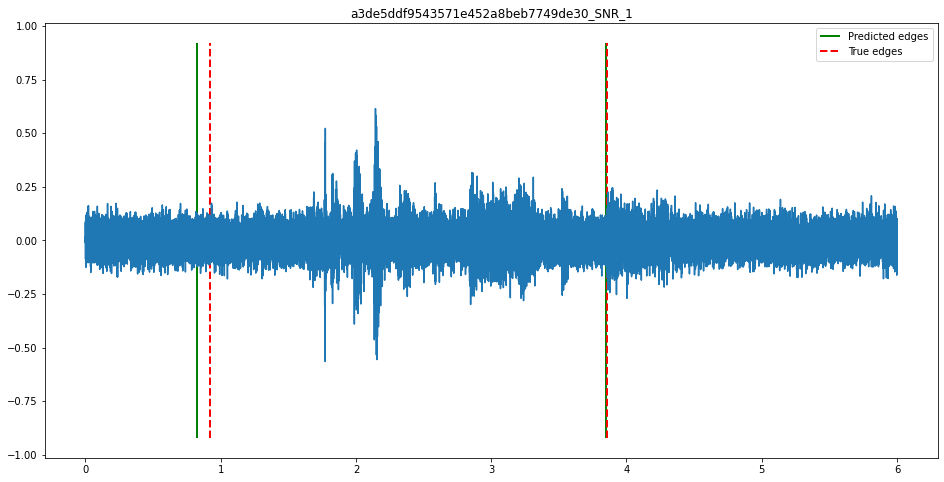

In [ ]:
num = randint(0, len(data_set_baseline['test']))
name, data, marks = data_set_baseline['test'][num]
model_baseline.eval()
pred = model_baseline(data.cuda().unsqueeze(0))
pred = torch.round(torch.sigmoid(pred))

sound_show(data, title=name, marks_true=marks, marks_pred=pred)

**MFCC**

In [ ]:
model_feature = ConvConvT2D().cuda()
checkpoint = torch.load('/content/gdrive/MyDrive/NN_MFCC_for_voice_segmentation_problem')
model_feature.load_state_dict(checkpoint['model_state_dict'])

metrics_test_compute(model_feature, loaders_feature_map)

NameError: ignored

{'Accuracy': 0.9527539169156145,
 'Precision': 0.9827302696404441,
 'Recall': 0.9200928427778517,
 'F1': 0.9483869423092429}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f880042b9d0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


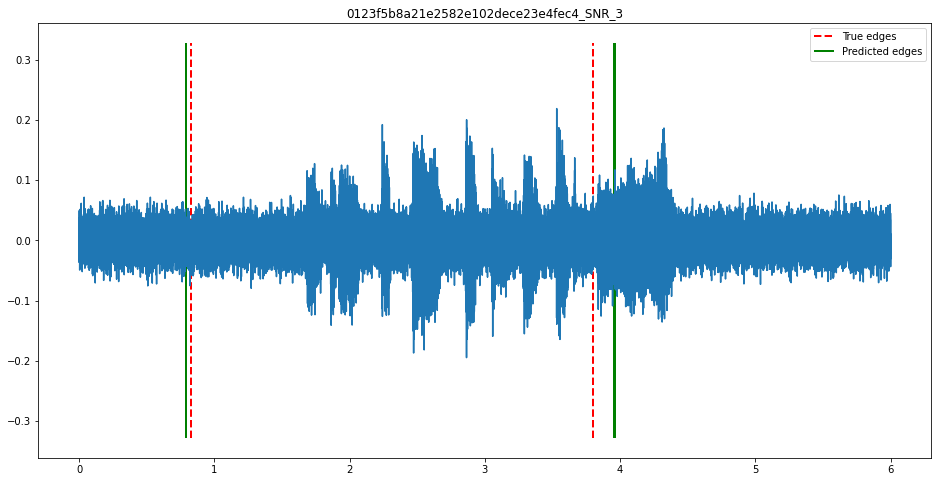

In [ ]:
num = randint(0, len(data_set_feature_map['test']))
name, data, marks, signal = data_set_feature_map['test'][num]
model_feature.eval()
pred = model_feature(data.cuda().unsqueeze(0))
pred = torch.round(torch.sigmoid(pred))

sound_show(signal, title=name, marks_true=marks, marks_pred=pred)

**eGMAPSv04**

In [ ]:
model_eGMAPSv02 = Conv_eGMAPSv02().cuda()
checkpoint = torch.load('/content/gdrive/MyDrive/eGMAPSv02_model_1')
model_eGMAPSv02.load_state_dict(checkpoint['model_state_dict'])



<All keys matched successfully>

In [ ]:
metrics_test_compute(model_eGMAPSv02, loaders_eGMAPSv02)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/10377 [00:00<?, ?it/s]

torch.Size([1, 1, 25, 596])


RuntimeError: ignored

In [ ]:
num = randint(0, len(data_set_eGMAPSv02['test']))
name, data, marks, signal = data_set_eGMAPSv02['test'][num]
model_feature.eval()
pred = model_eGMAPSv02(data.cuda().unsqueeze(0))
pred = torch.round(torch.sigmoid(pred))

sound_show(signal, title=name, marks_true=marks, marks_pred=pred)

RuntimeError: ignored